In [131]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl


In [132]:
USER='wilderlavington'
PROJECT='FunctionalStochasticOptimization'
SUMMARY_FILE='sharan_report_0831.csv'
EPISODES = 25000
K=2

In [133]:
def smooth(array, k):
    array = np.array(array)
    new_array = deepcopy(array)
    # print(array[max(0,i-k):i] )
    for i in range(len(array)):
        if str(array[i]) != 'nan':
            avg_list = [val for val in array[max(0,i-k):i+1] if str(val) != 'nan']
            new_array[i] = sum(avg_list) / len(avg_list)
    return new_array

In [134]:
def format_dataframe(records, id_subfields={}, avg_subfields=['seed'],
            max_subfields=['log_eta', 'eta_schedule', 'c'],
            x_col='optim_steps', y_col='avg_loss'):
    #
    pd.set_option('display.max_columns', None)
    max_subfields = [m for m in max_subfields if m not in id_subfields.keys()]

    for key in id_subfields: 
        records = records.loc[records[key] == id_subfields[key]]
    records['function_evals+grad_evals'] = records['function_evals']+records['grad_evals']
    if not len(records):
        return None
    # remove nans
    records = records[records[y_col].notna()]
    important_cols = list(set(avg_subfields+max_subfields+\
        list(id_subfields.keys())+[x_col, y_col, 'optim_steps']))
    # remove redundant information
    records = records[important_cols]
    # average over avg_subfields
    records = records.drop(avg_subfields, axis=1)
    # group over averaging field
    gb = list(set(list(max_subfields+list(id_subfields.keys())+[x_col, 'optim_steps'])))
    # only look at final optim steps
    last_mean_records = records.loc[records['optim_steps'] == records['optim_steps'].max()]
    # get the best record
    best_record = last_mean_records[last_mean_records[y_col] == last_mean_records[y_col].min()]
    # find parameters of the best record
    merge_on = list(set(gb)-set(['optim_steps', x_col, y_col]))
    merge_on = [ x for x in merge_on if x in best_record.columns.values]
    best_records = pd.merge(best_record[merge_on], records, on=merge_on,how='left')
    final_records = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].mean()
    final_records[y_col+'25'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.25)[y_col]
    final_records[y_col+'75'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.75)[y_col]
    final_records = final_records.sort_values(x_col, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    # smooth outputs 
    final_records[y_col+'75'] = smooth(final_records[y_col+'75'],K)
    final_records[y_col+'25'] = smooth(final_records[y_col+'25'],K)
    final_records[y_col] = smooth(final_records[y_col],K)
    return final_records

In [147]:
def generate_plot(proc_df, x, y, ax, label, linestyle='solid', color=None):
    low_order_idx = (torch.tensor(proc_df[x].values) < x_max).nonzero().reshape(-1)
    if label:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label=label, linestyle=linestyle, color=color,
                linewidth=4)
    else:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label='_nolegend_', linestyle=linestyle, color=color,
                linewidth=4)
    ax.fill_between(torch.tensor(proc_df[x].values)[low_order_idx],
            torch.tensor(proc_df[y+'75'].values)[low_order_idx],
            torch.tensor(proc_df[y+'25'].values)[low_order_idx],
            alpha = 0.5, label='_nolegend_', linestyle=linestyle, color=color)
    return ax

In [158]:
def generate_A1_figure(loss, dataset_name, wandb_records):
    
    # base info   
    schedules = ['constant', 'stochastic', 'exponential']
    batch_sizes = [25, 125, 625]
    m = [1, 2, 5, 10, 20]
    x = 'time_elapsed'
    y = 'grad_norm'
    
    # init plots 
    fig, axs = plt.subplots(SCHEDULES, BATCHES, figsize=(21, 7), sharex=True, sharey=True)
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD':colors[0], 'SLS':colors[1]}.\
        update({'FuncOpt'+str(m_):colors[idx+2] for idx, m_ in enumerate(m)})
    plt.title('Comparison of SGD/SLS/FuncOpt: '+loss+'-'+dataset_name)
    label_map = {x:'Time-Elapsed', y:'Gradient-Norm'}
    # now add in the lines to each of the plots 
    for row, schedule in enumerate(schedules):
        for col, batch_size in enumerate(batch_sizes):
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y)
            if proc_df:
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label=None, 
                                             linestyle='dotted', color=colormap['SLS'])
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df:
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label=None, 
                                             linestyle='dotted', color=colormap['SGD'])
            
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                        'use_optimal_stepsize': 1,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col='grad_norm', y_col='time_elapsed')
                # generate the associated plot 
                if proc_df:
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label, color=colormap['FuncOpt'+str(m_)])
            
            # FMDopt grid_searched  
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                        'use_optimal_stepsize': 0,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['log_eta', 'c'],
                    x_col='grad_norm', y_col='time_elapsed') 
                if proc_df:
                    ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                           linestyle='dotted', color=colormap['FuncOpt'+str(m_)])
            axs[row][col].grid()    
            axs[row][col].set_title('schedule: '+schedule+', batch_size: '+str(batch_size), fontsize=20)
            axs[row][col].set_xlabel(label_map[x], fontsize=16)
            axs[row][col].set_ylabel(label_map[y], fontsize=16)
            axs[row][col].tick_params(axis='both', which='major', labelsize=14)
            axs[row][col].tick_params(axis='both', which='minor', labelsize=14)
    # remaining format stuff 
    plt.legend()
    plt.yscale("log")
    plt.rcParams['figure.dpi'] = 400 
    plt.suptitle('Comparison of SGD/SLS/FuncOpt: Loss: '+loss+', Dataset: '+dataset_name, fontsize=28)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    # show / save
    plt.savefig(loss+'_'+dataset_name+'.pdf', bbox_inches='tight')
    plt.show() 

In [156]:
def generate_A2_figure(loss, dataset_name, wandb_records):
    
    # base info   
    schedules = ['constant']
    batch_sizes = [25, 125, 625]
    m = [1, 2, 5, 10, 20]
    x = 'time_elapsed'
    y = 'grad_norm'
    
    # init plots 
    fig, axs = plt.subplots(len(schedules), len(batch_sizes), figsize=(21, 7), sharex=True, sharey=True)
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD':colors[0], 'SLS':colors[1]}.\
        update({'FuncOpt'+str(m_):colors[idx+2] for idx, m_ in enumerate(m)})
    axs = [axs]
    label_map = {x:'Time-Elapsed', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, schedule in enumerate(schedules):
        for col, batch_size in enumerate(batch_sizes):
            
            # Adagrad
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df:
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label=None, 
                                             linestyle='dotted', color=colormap['Adagrad'])
            
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                        'use_optimal_stepsize': 0, 'log_eta': -3, 
                        'loss': loss, 'algo': 'Ada_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col='grad_norm', y_col='time_elapsed')
                # generate the associated plot 
                if proc_df:
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label, color=colormap['FuncOpt'+str(m_)])
                
            # FMDopt grid_searched  
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size, 'episodes': EPISODES,
                        'use_optimal_stepsize': 0,
                        'loss': loss, 'algo': 'Ada_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['log_eta', 'c'],
                    x_col='grad_norm', y_col='time_elapsed') 
                if proc_df:
                    axs[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                           linestyle='dotted', color=colormap['FuncOpt'+str(m_)])
            axs[row][col].grid()    
            axs[row][col].set_title('schedule: '+schedule+', batch_size: '+str(batch_size), fontsize=20)
            axs[row][col].set_xlabel(label_map[x], fontsize=16)
            axs[row][col].set_ylabel(label_map[y], fontsize=16)
            axs[row][col].tick_params(axis='both', which='major', labelsize=14)
            axs[row][col].tick_params(axis='both', which='minor', labelsize=14)
    # remaining format stuff 
    plt.legend()
    plt.yscale("log")
    plt.rcParams['figure.dpi'] = 400 
    plt.suptitle('Comparison of Adagrad/Ada-FuncOpt: Loss: '+loss+', Dataset: '+dataset_name, fontsize=28)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    # show / save
    plt.savefig('Adaptive_'+loss+'_'+dataset_name+'.pdf', bbox_inches='tight')
    plt.show() 

generating SGD plot for  mushrooms MSELoss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


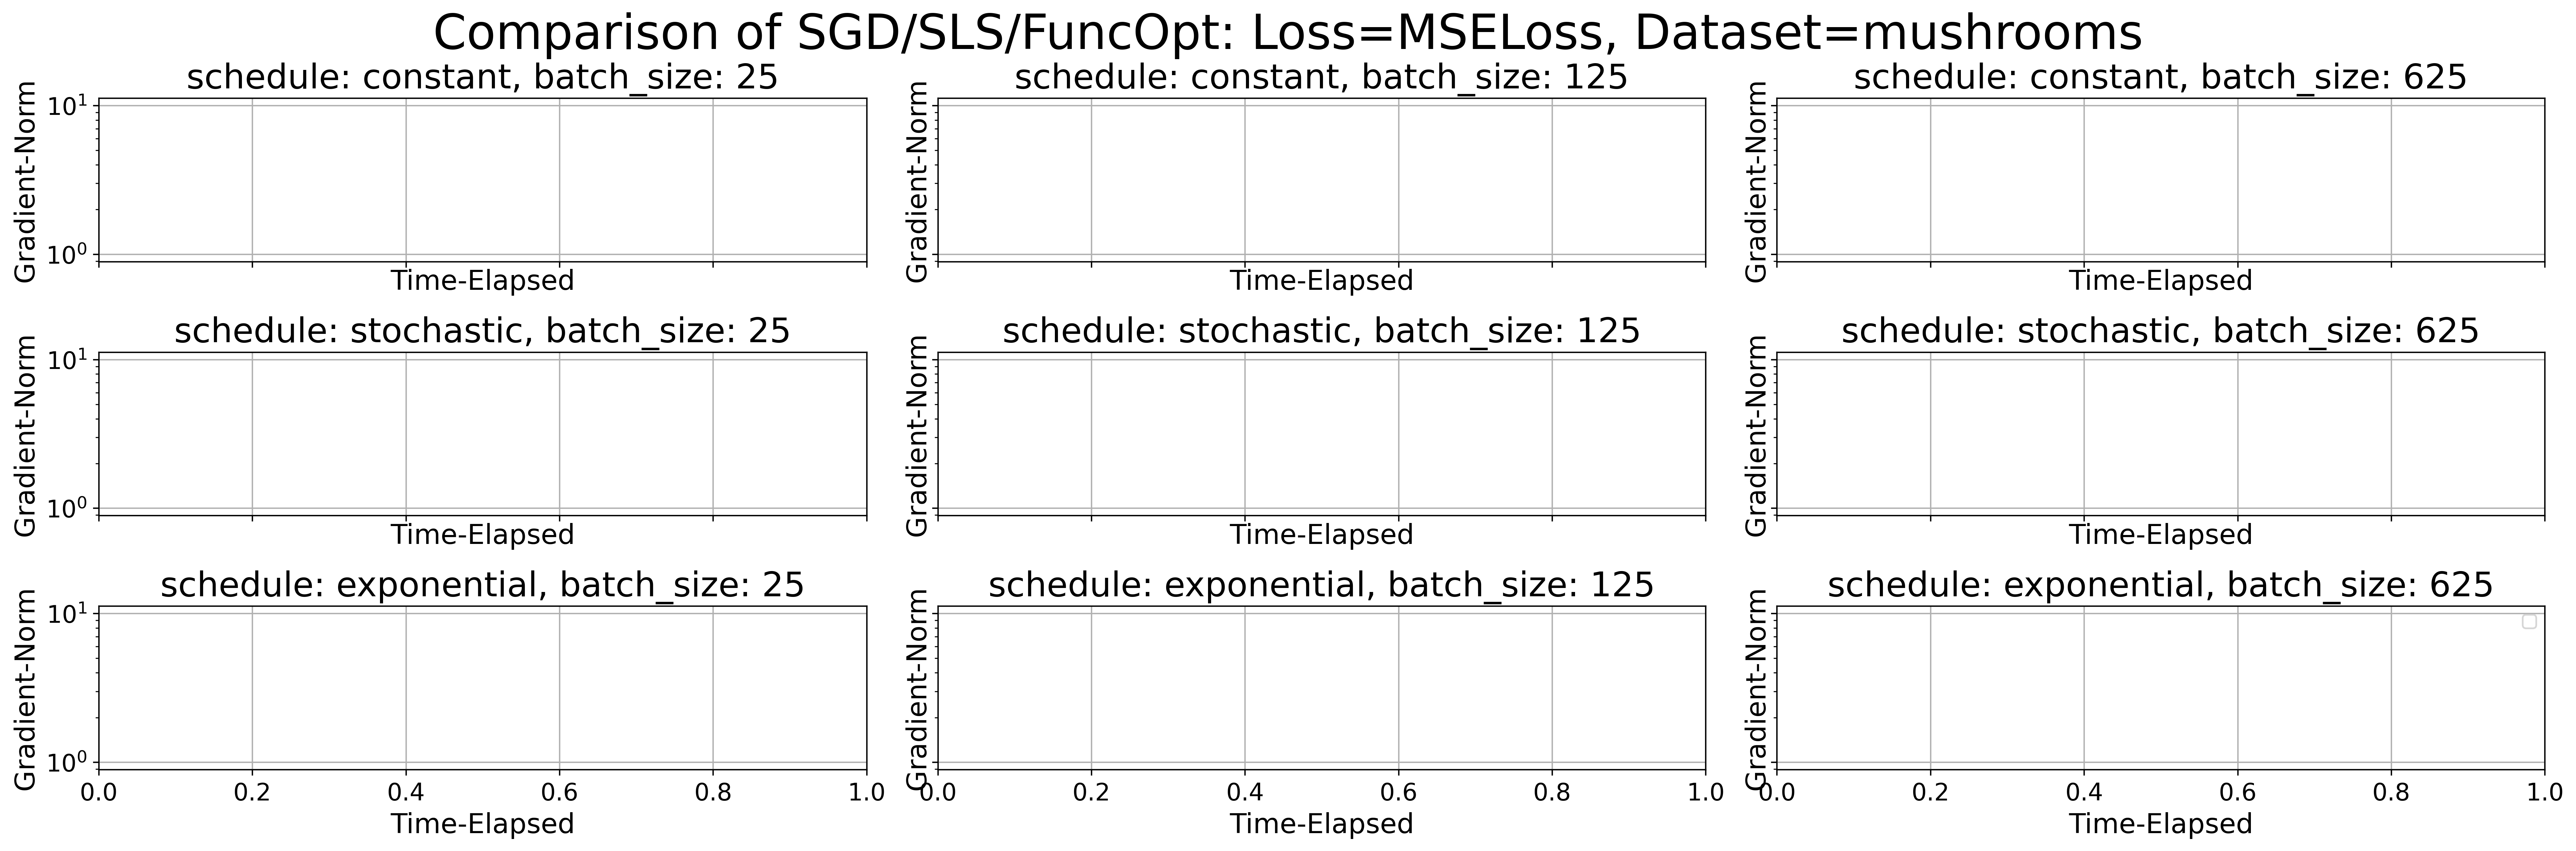

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


generating Adagrad plot for  mushrooms MSELoss


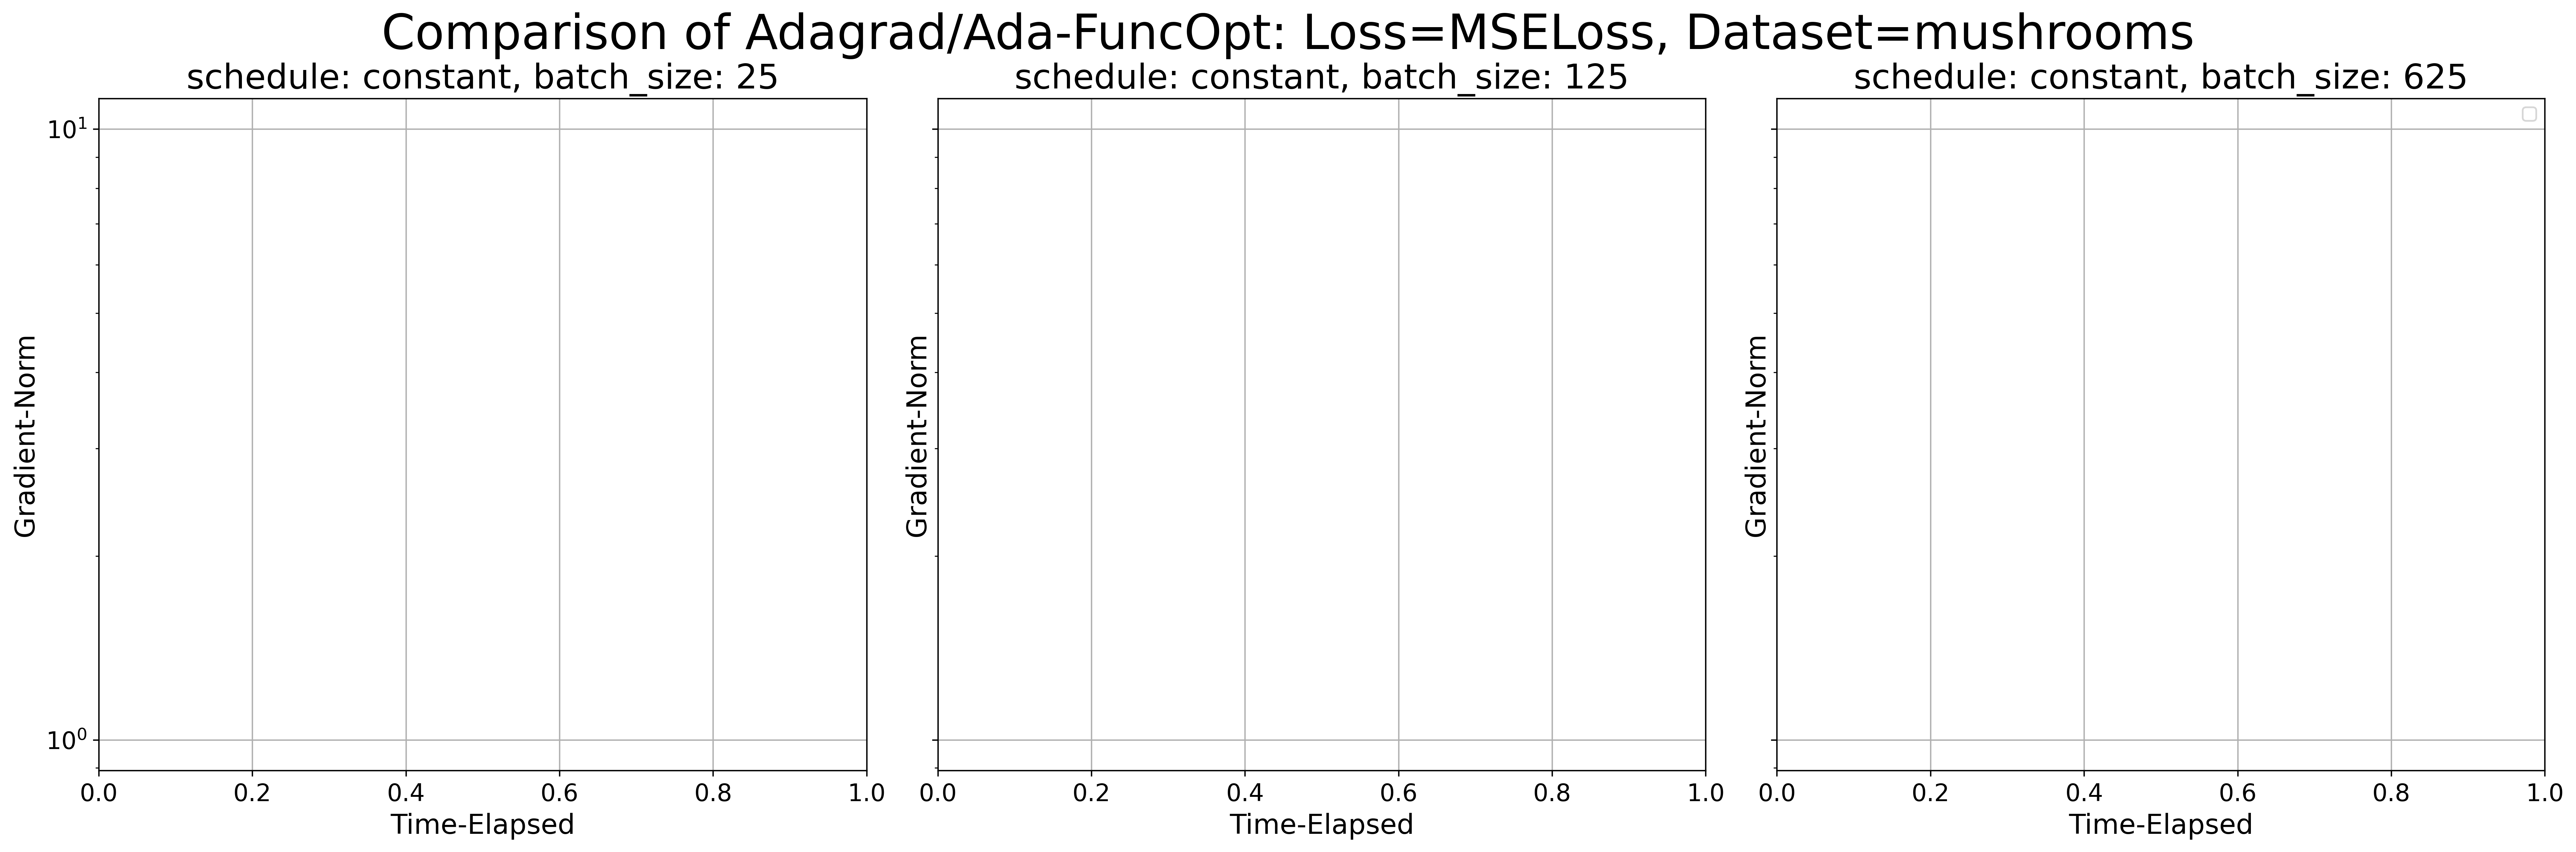

generating SGD plot for  mushrooms BCEWithLogitsLoss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


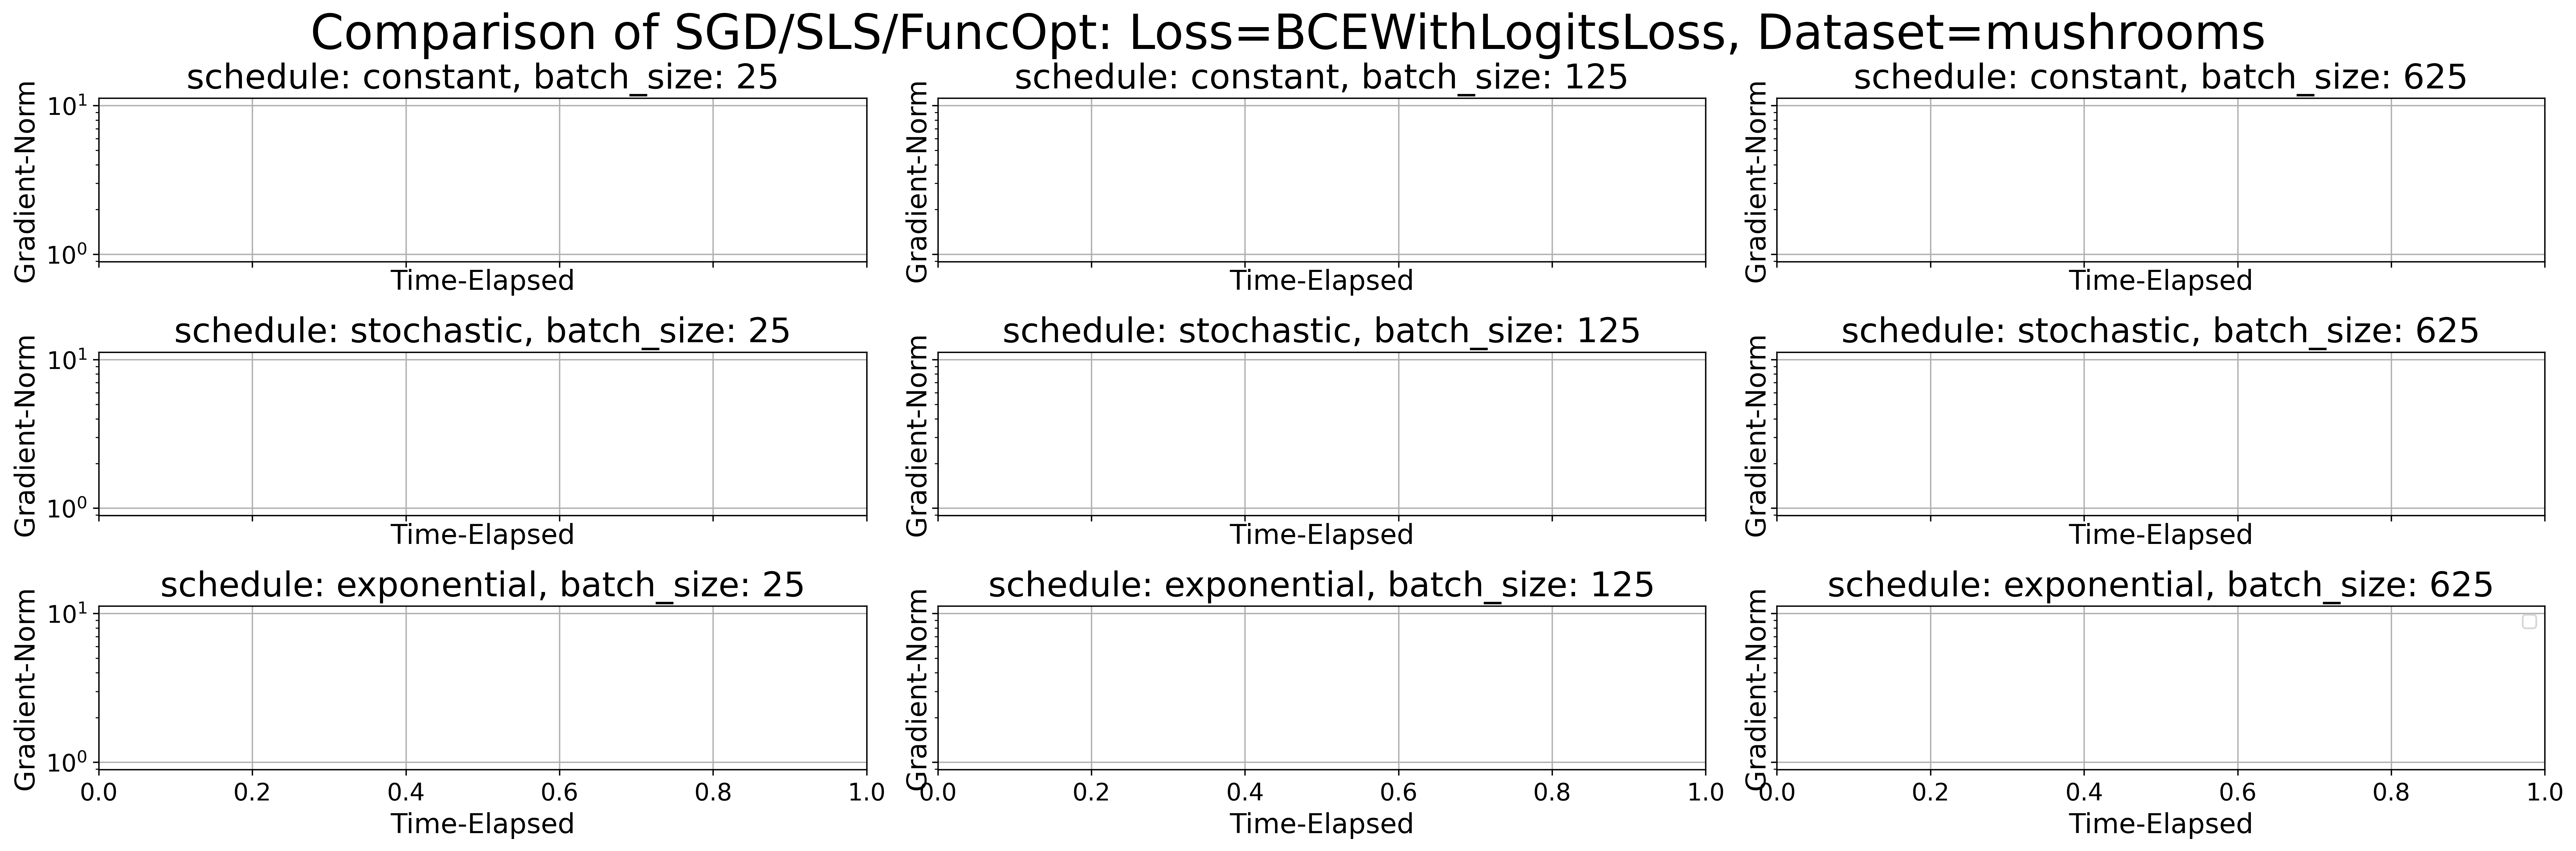

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


generating Adagrad plot for  mushrooms BCEWithLogitsLoss


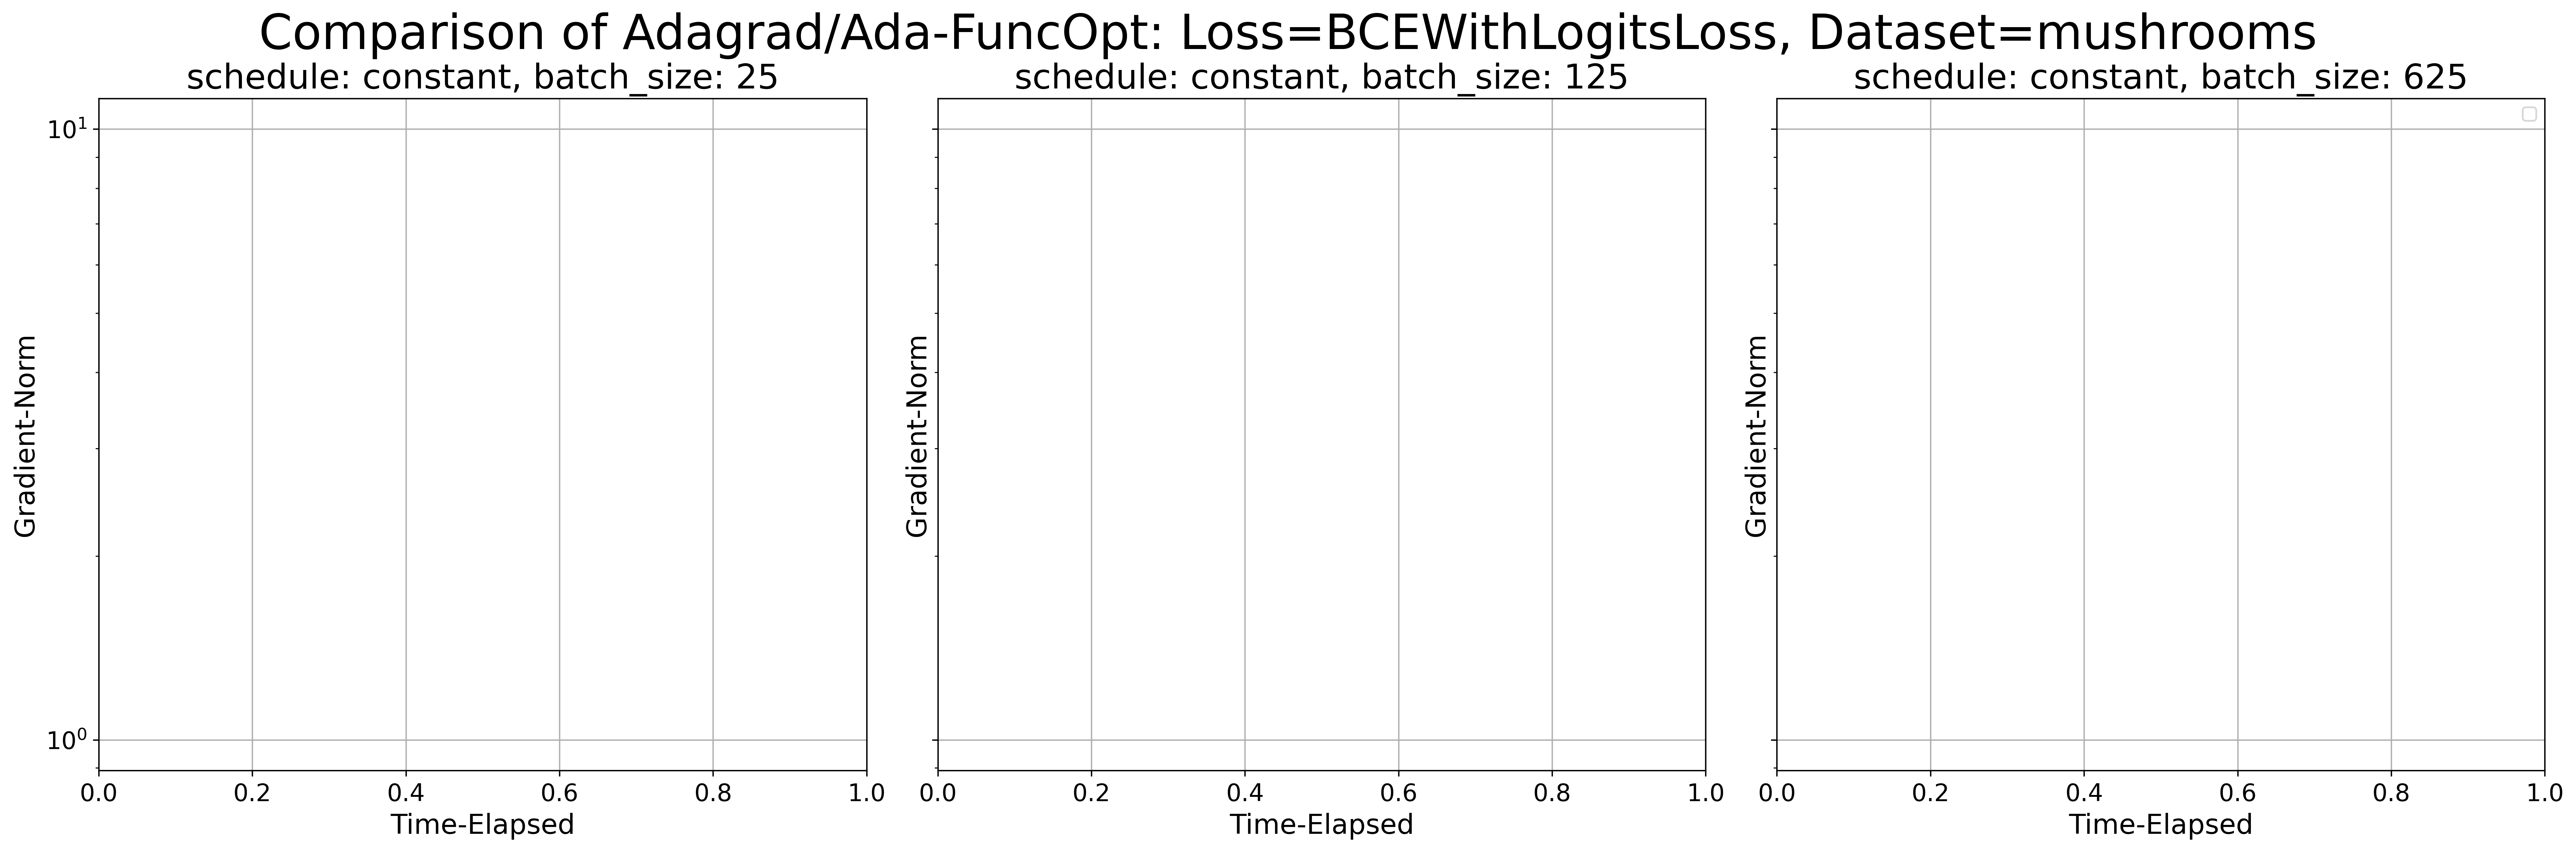

generating SGD plot for  ijcnn MSELoss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


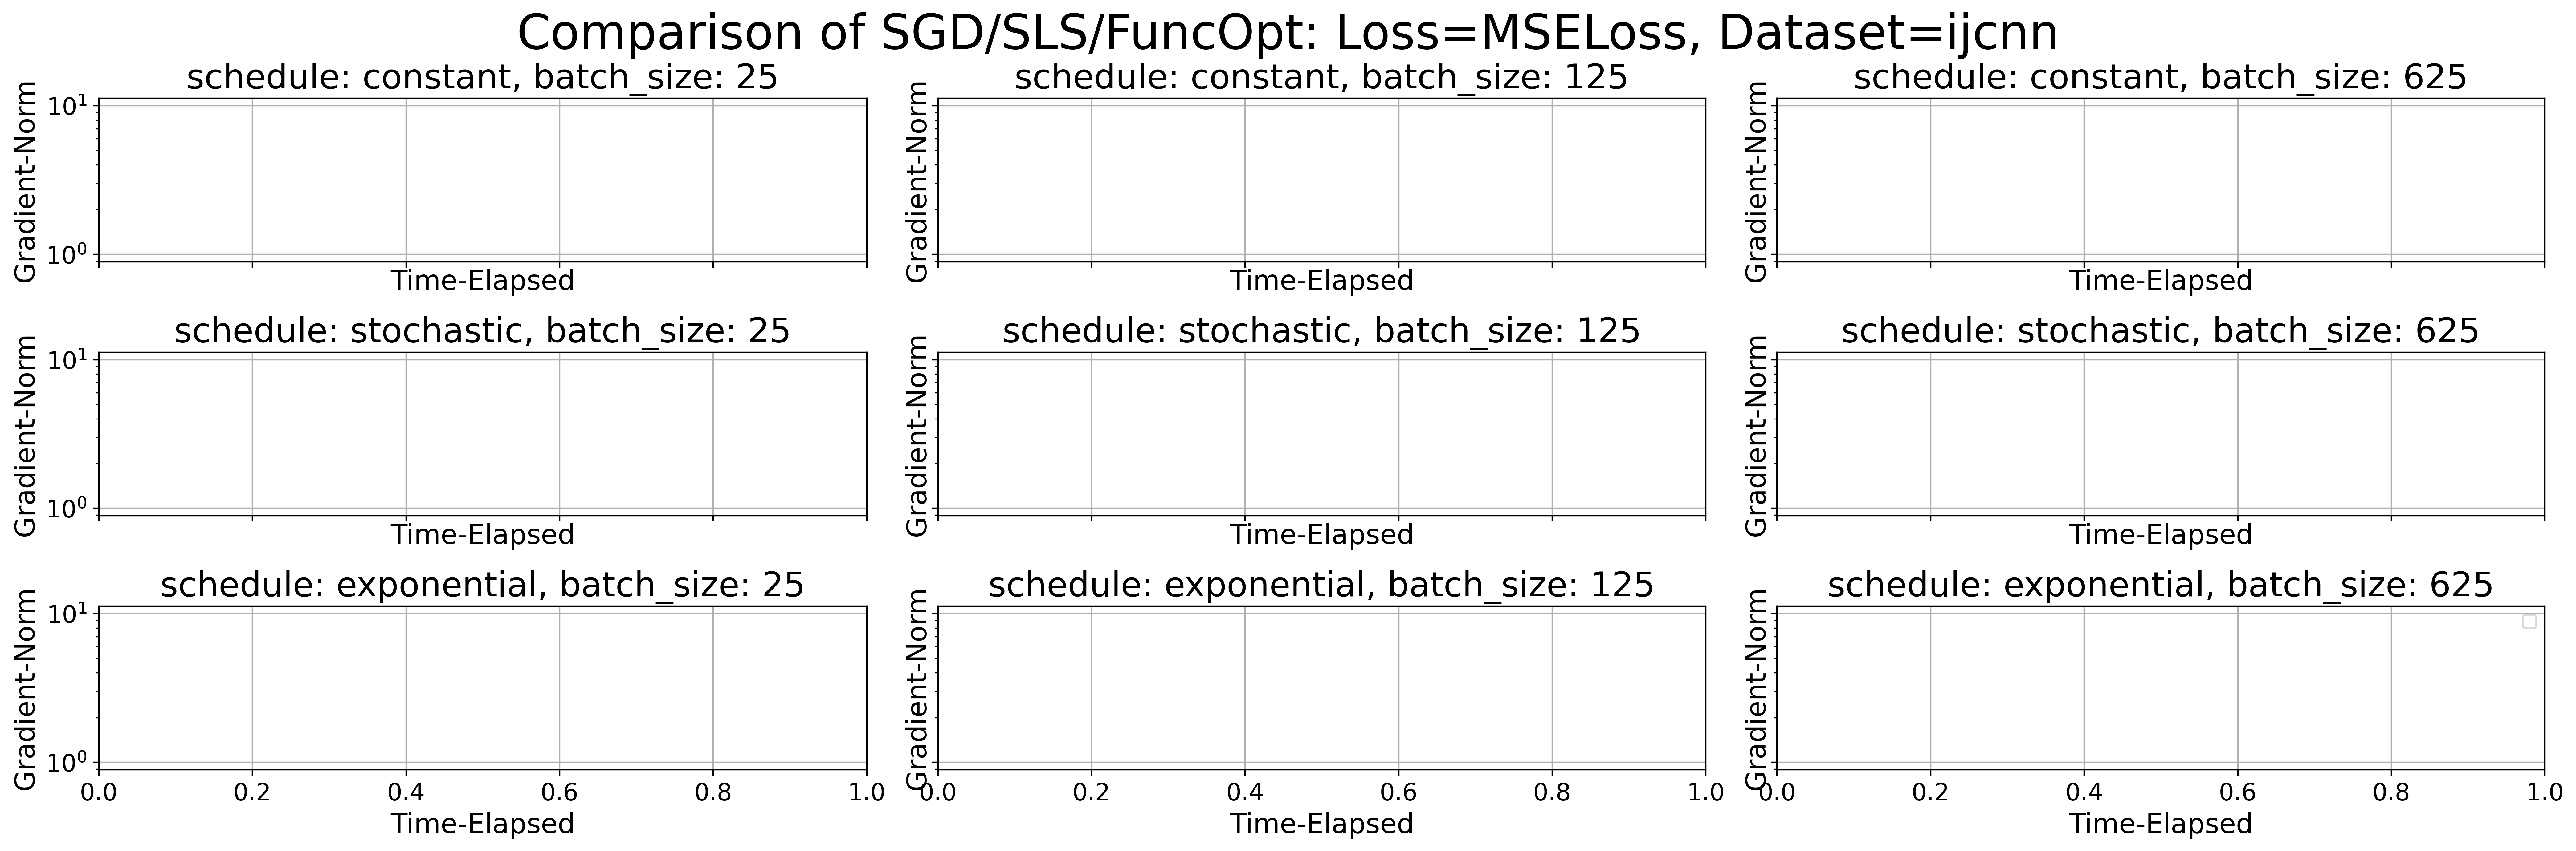

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


generating Adagrad plot for  ijcnn MSELoss


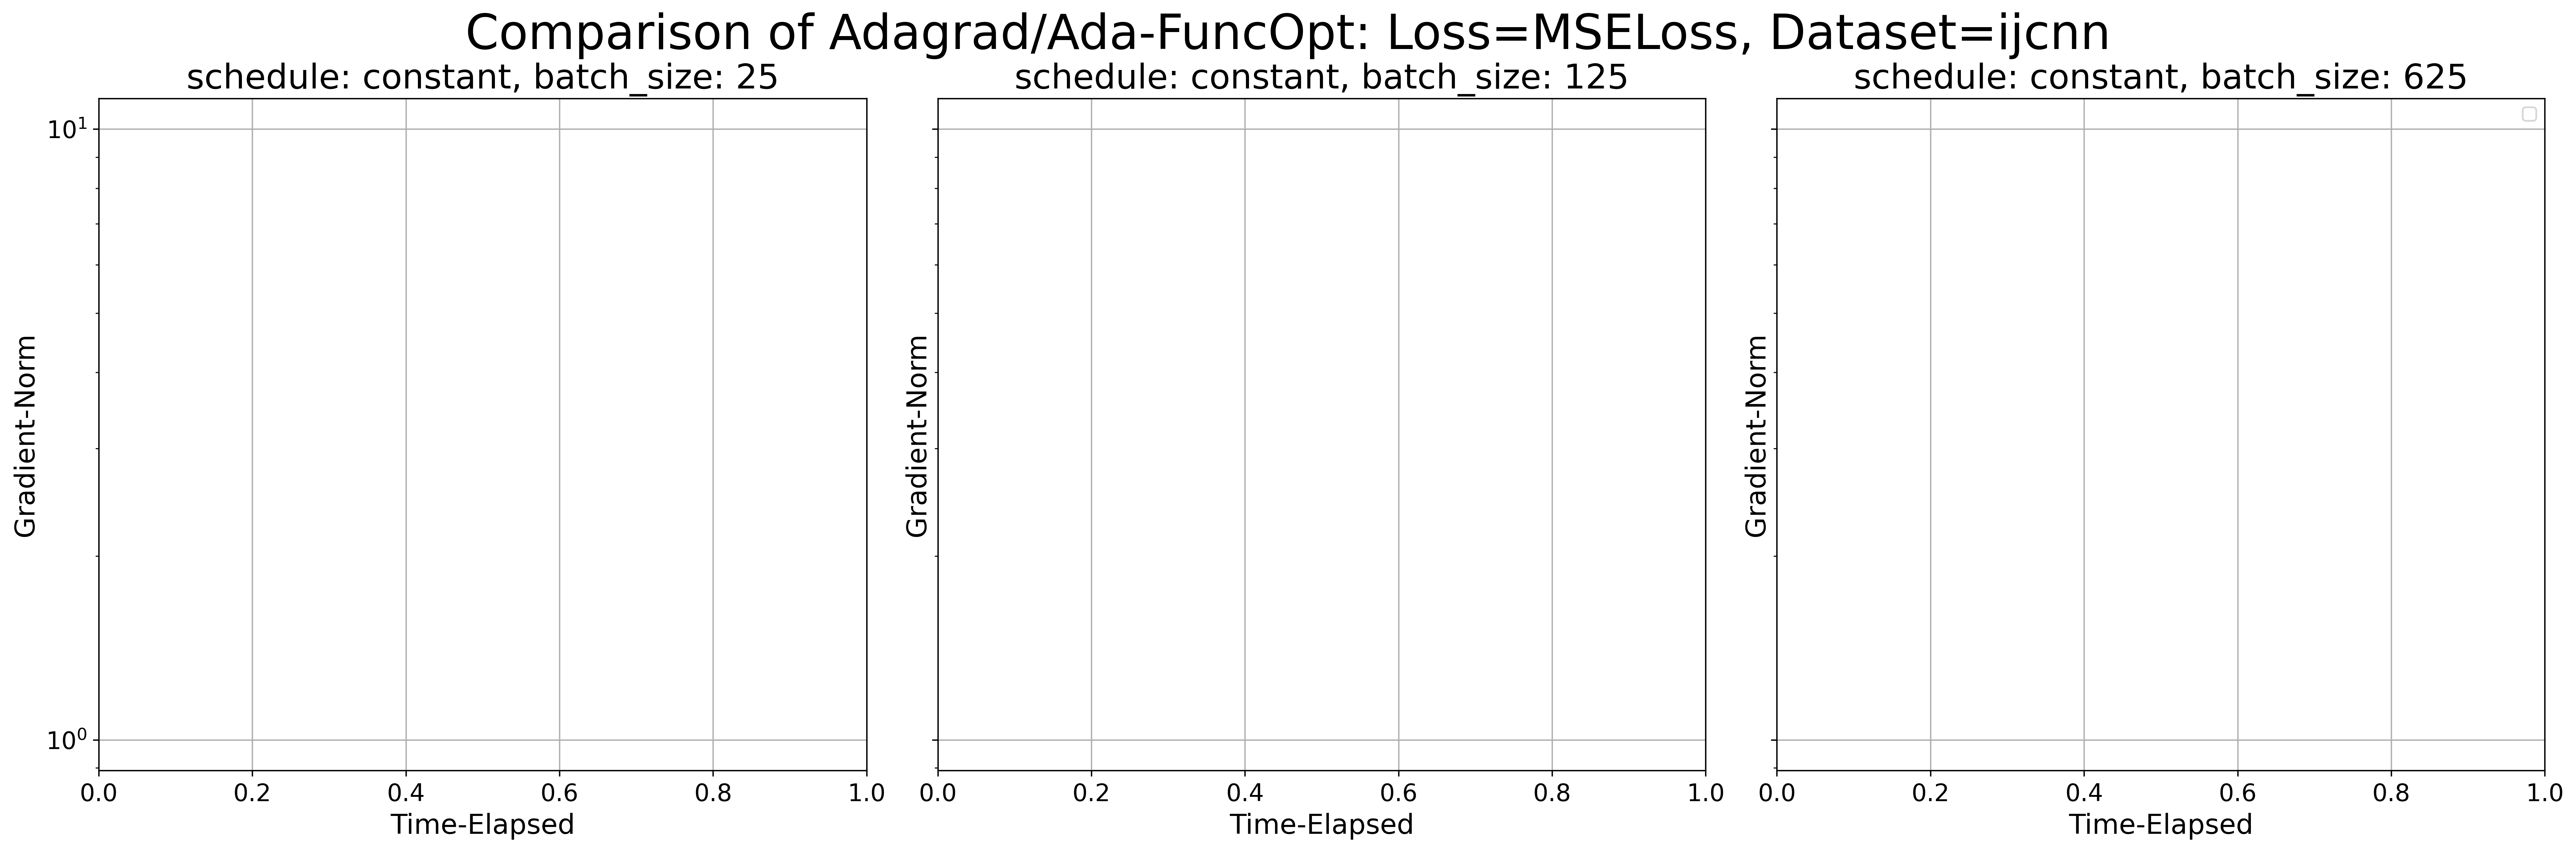

generating SGD plot for  ijcnn BCEWithLogitsLoss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


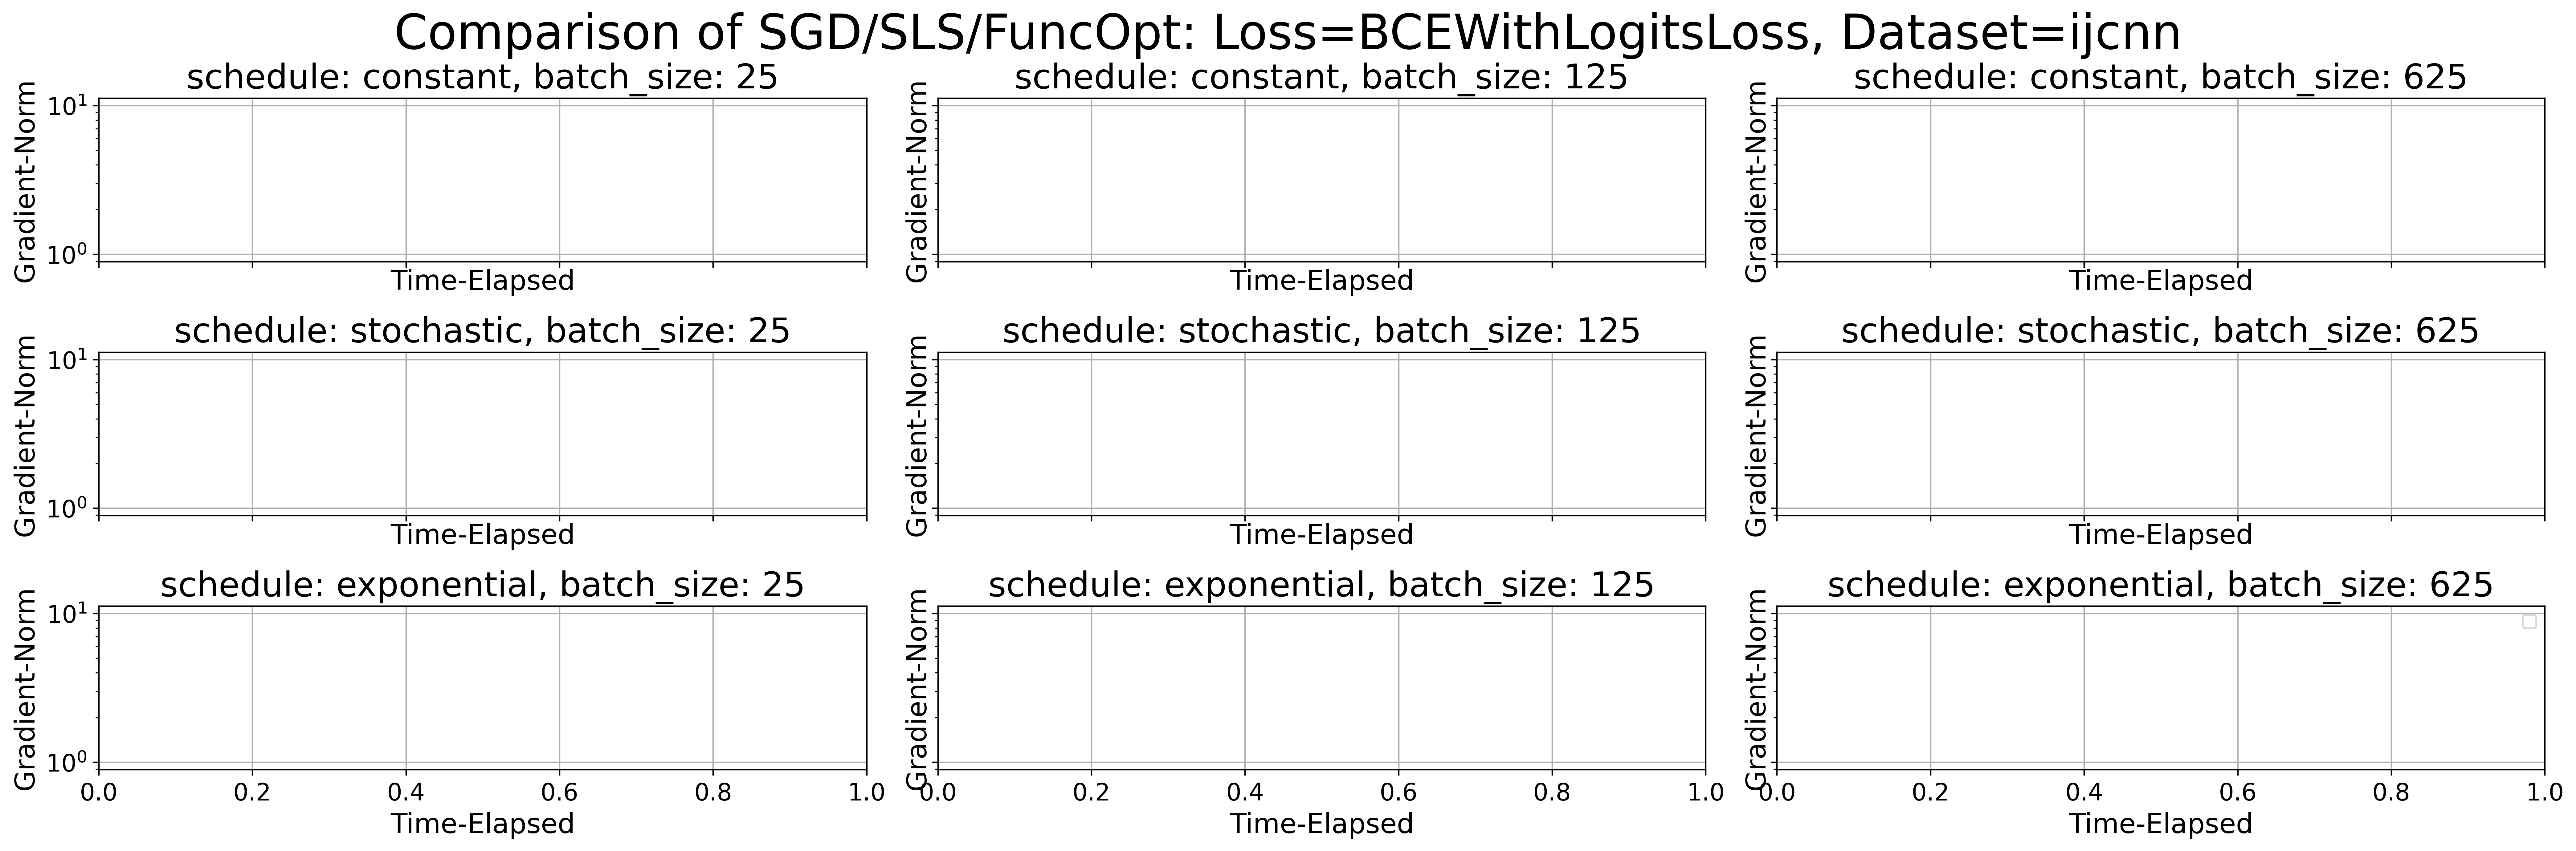

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


generating Adagrad plot for  ijcnn BCEWithLogitsLoss


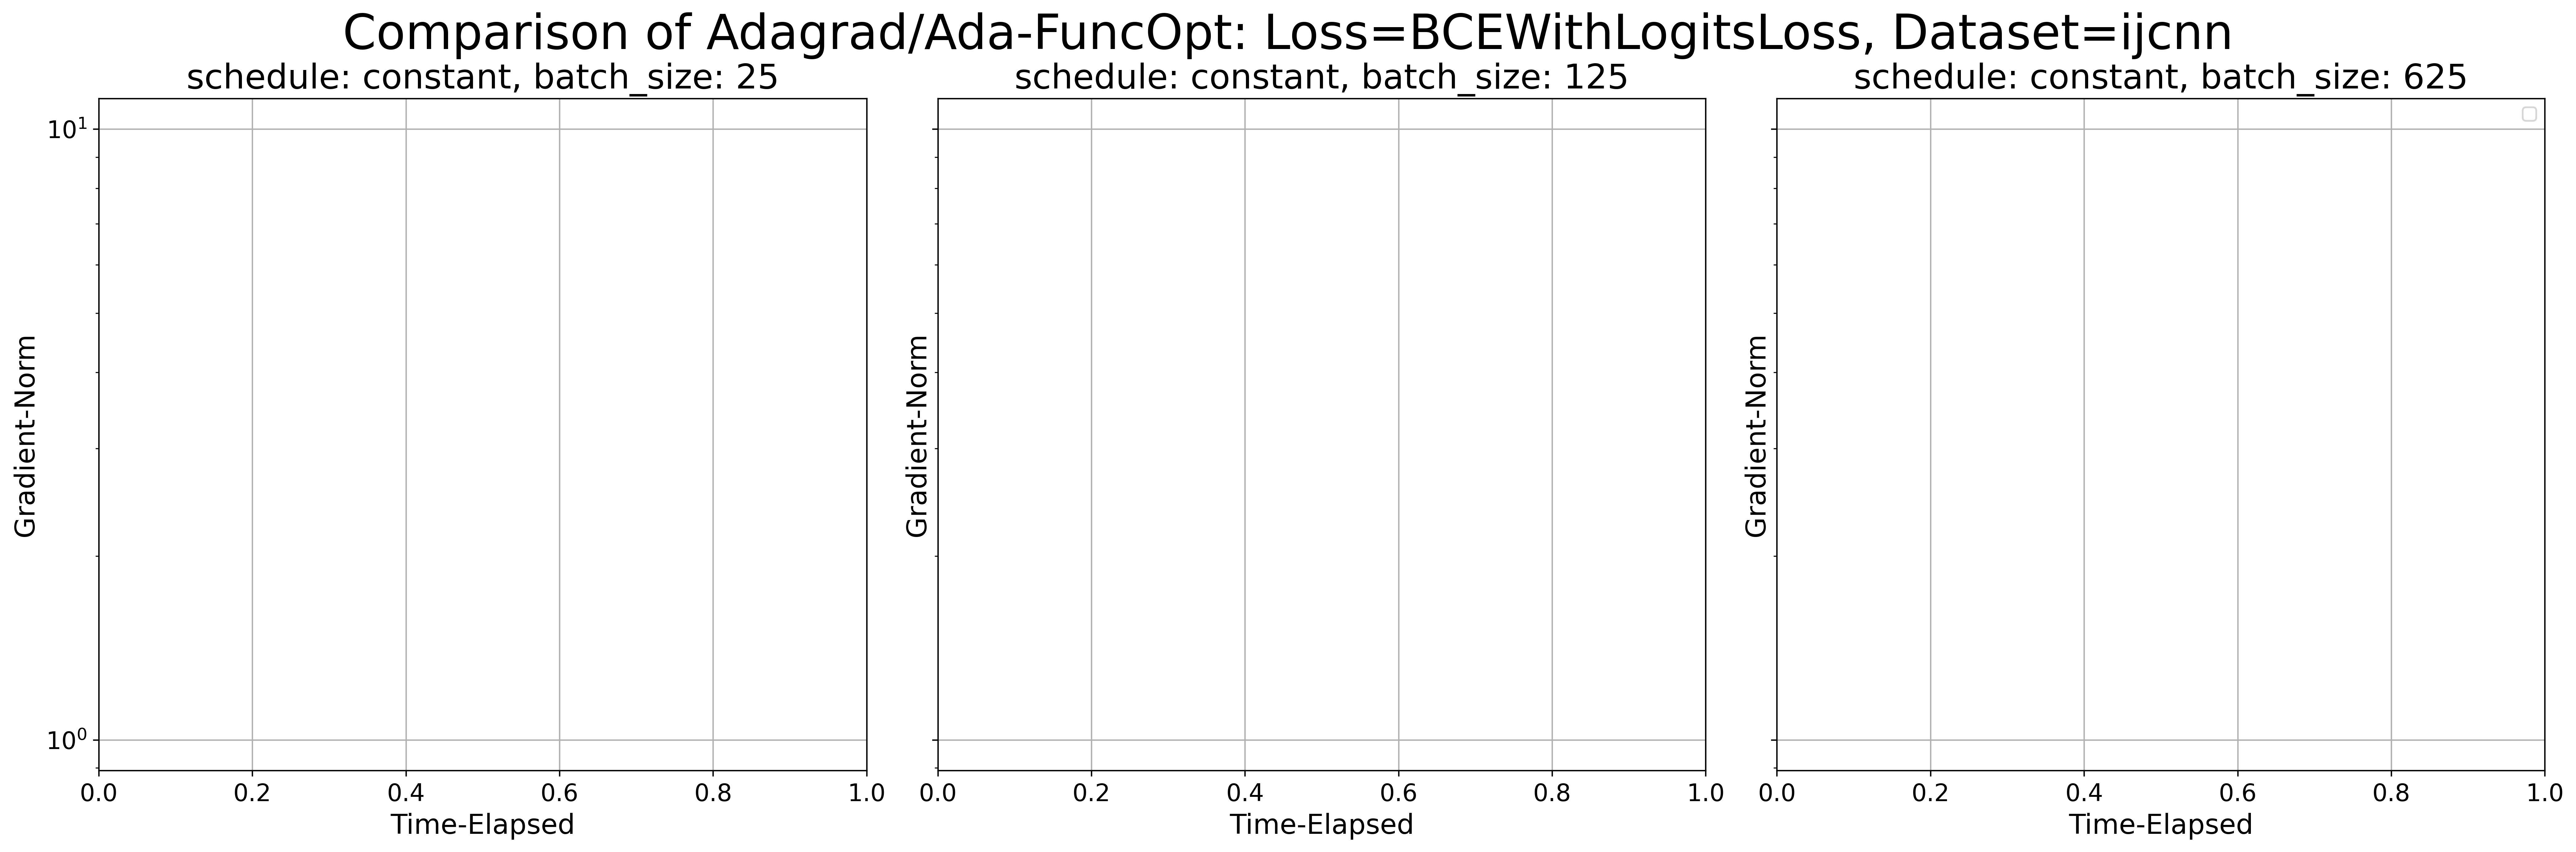

generating SGD plot for  rcv1 MSELoss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


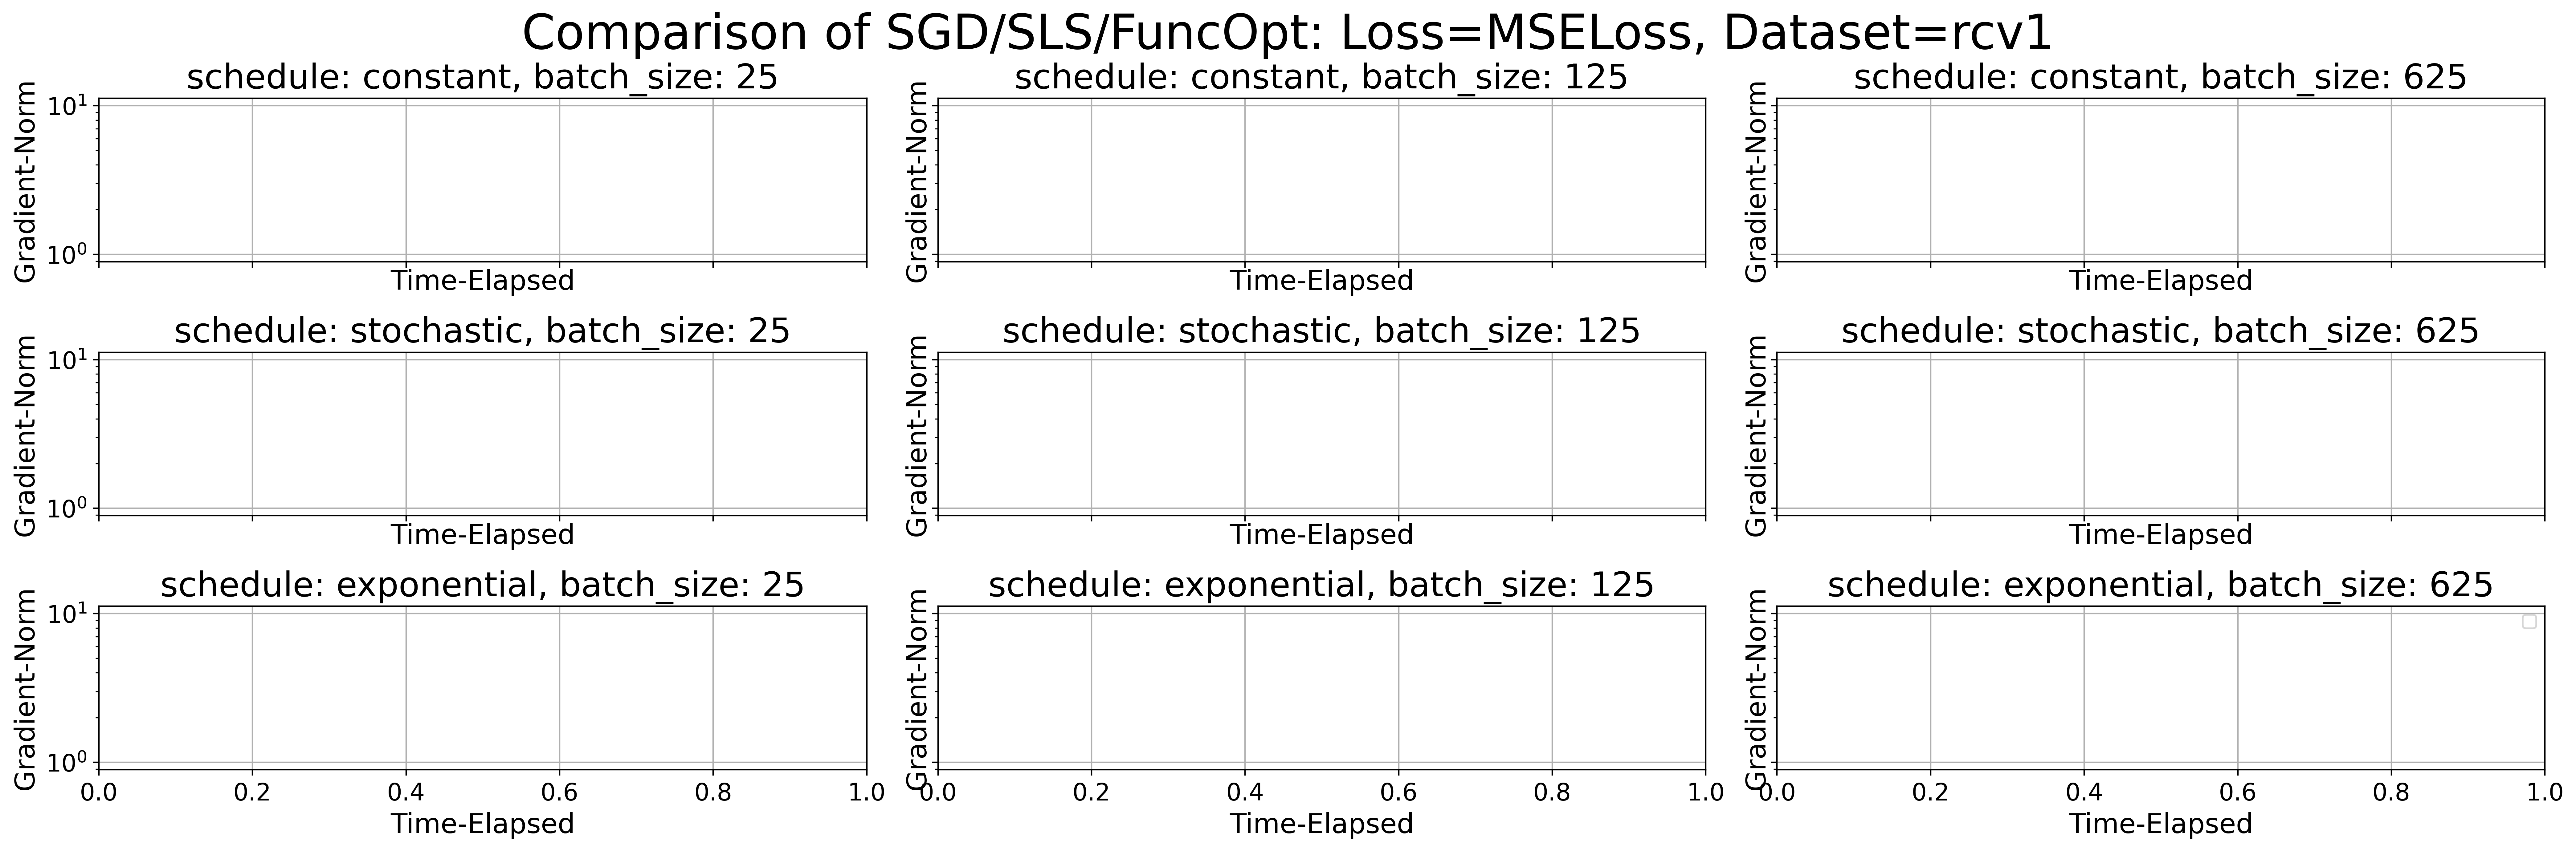

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


generating Adagrad plot for  rcv1 MSELoss


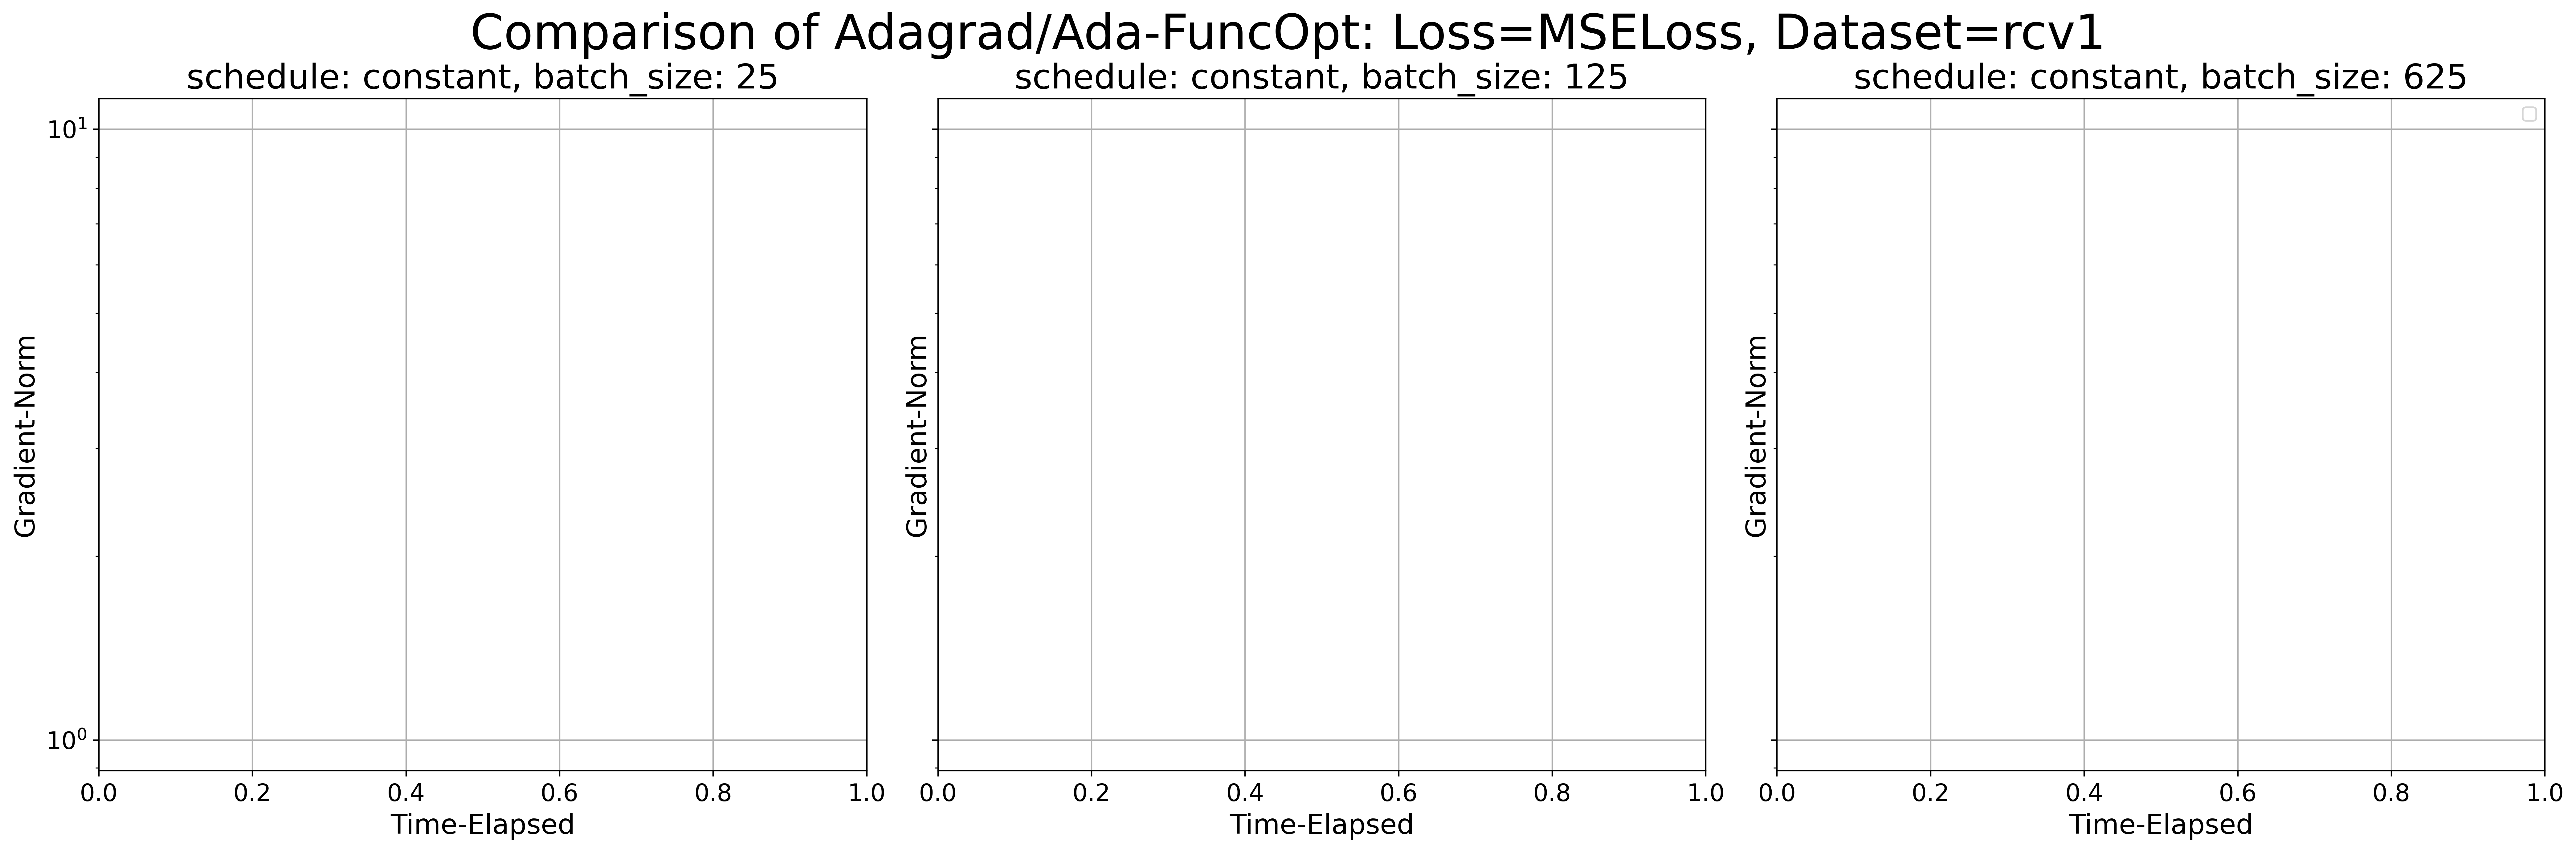

generating SGD plot for  rcv1 BCEWithLogitsLoss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


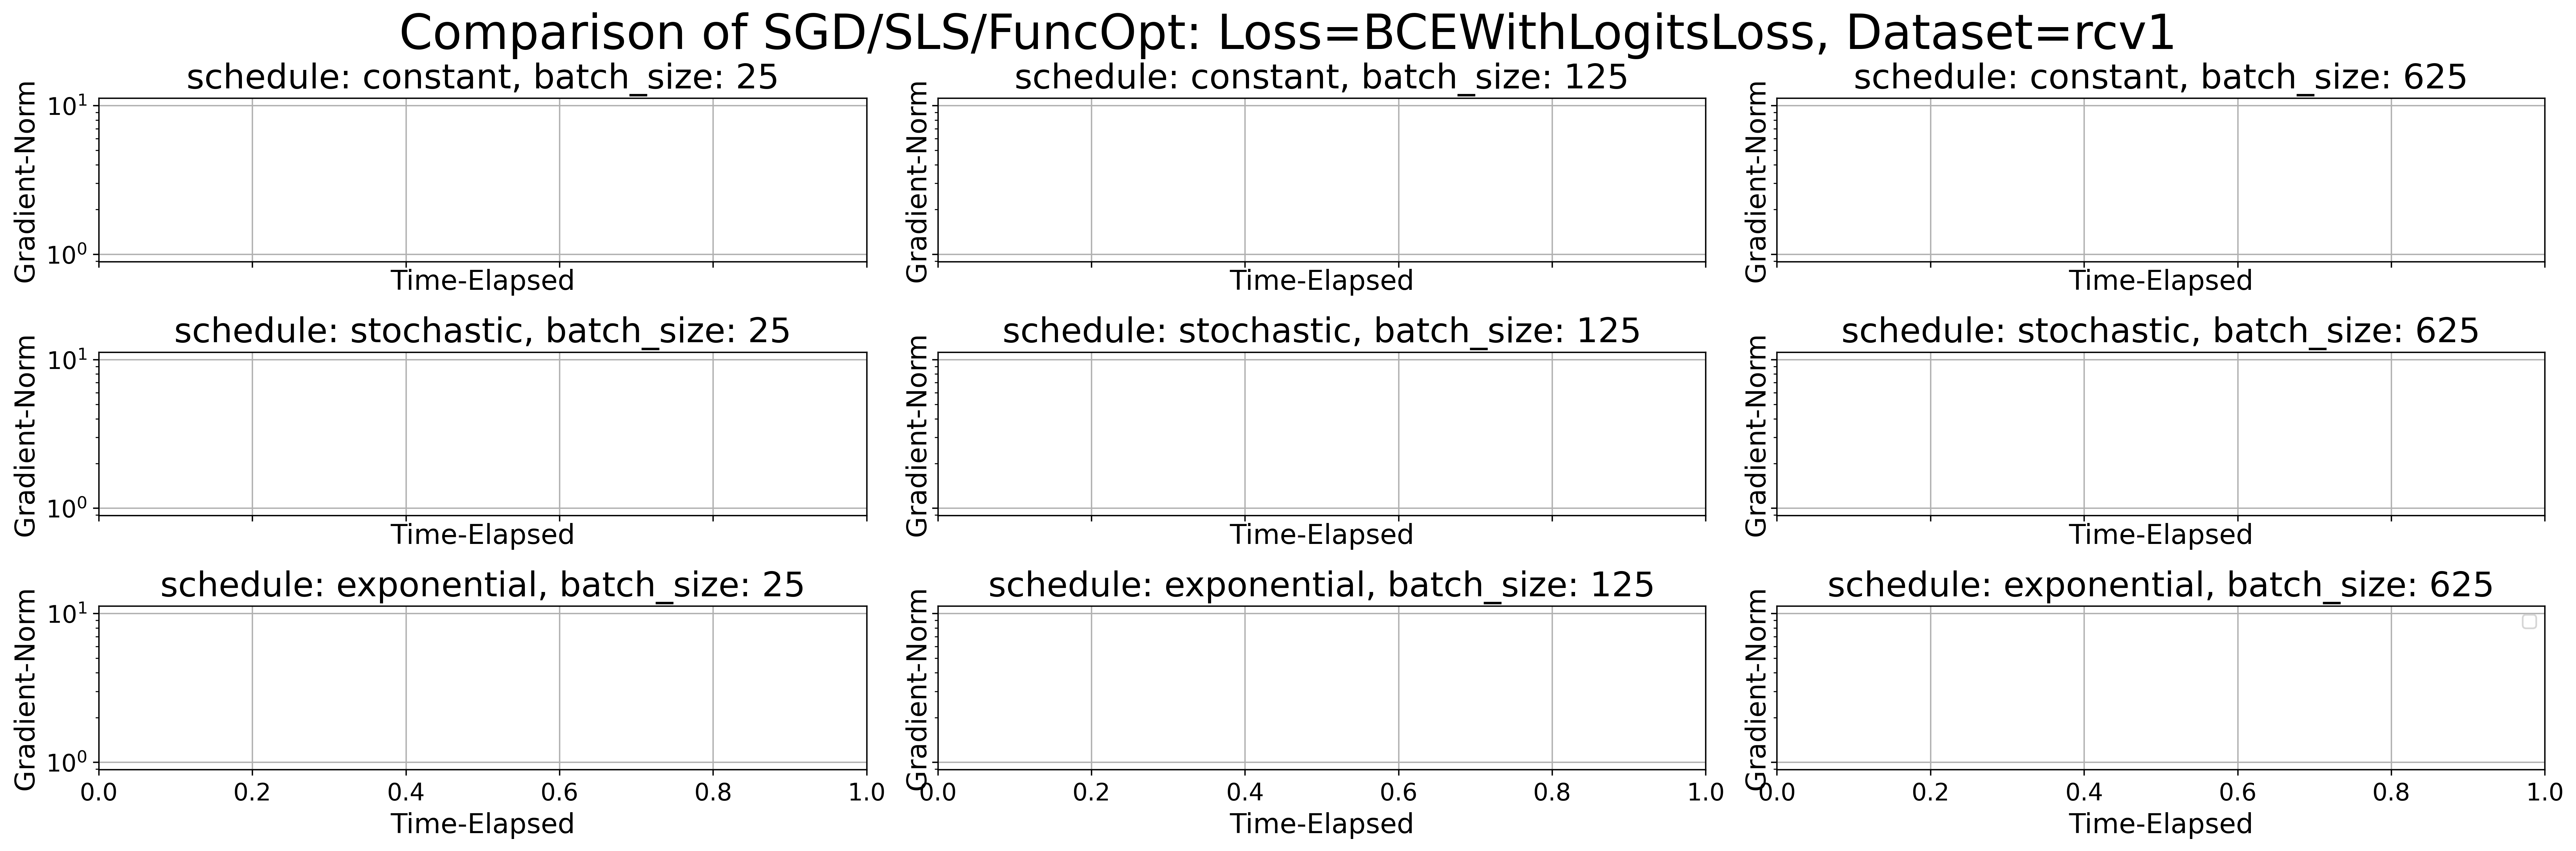

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


generating Adagrad plot for  rcv1 BCEWithLogitsLoss


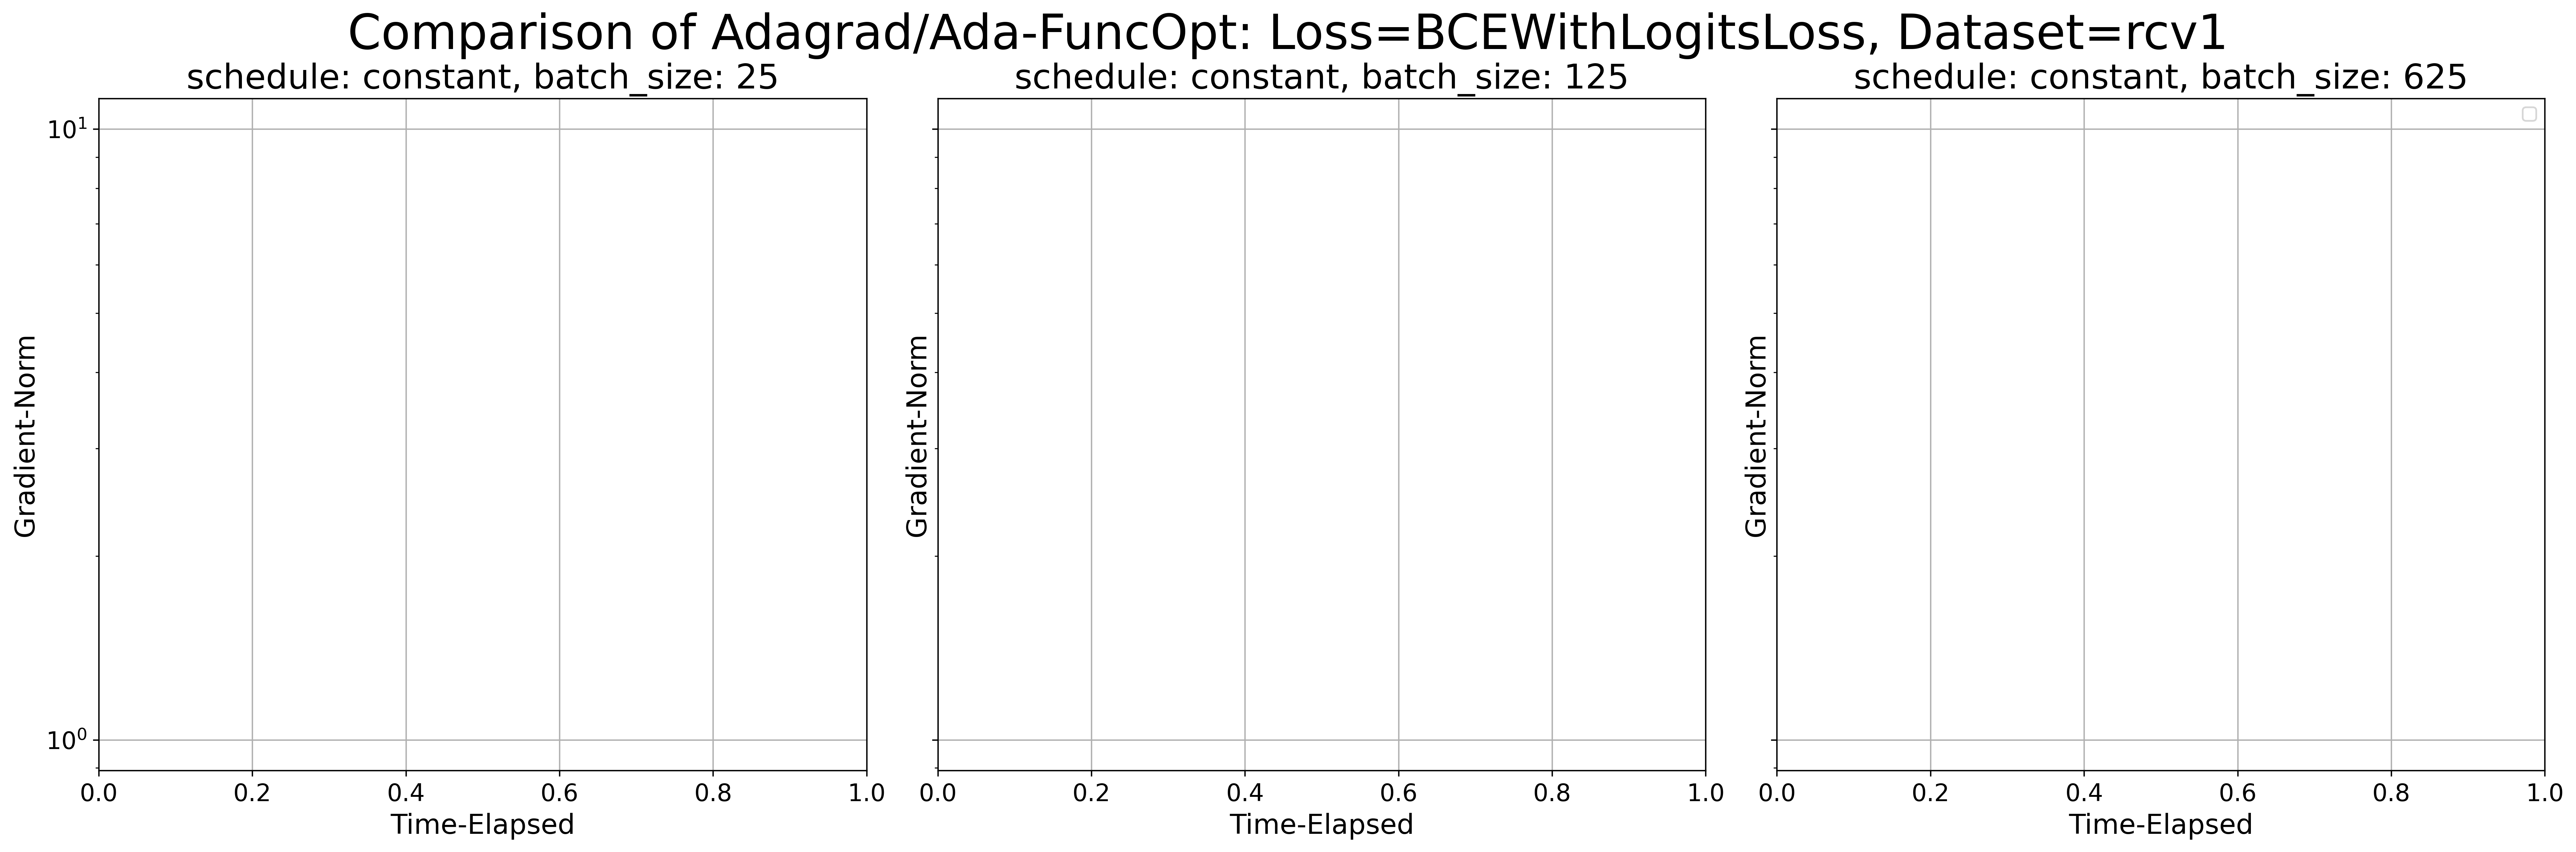

In [157]:
data_sets = ['mushrooms', 'ijcnn', 'rcv1']
losses = ['MSELoss', 'BCEWithLogitsLoss']
wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)
for data_set in data_sets:
    for loss in losses:
        print('generating SGD plot for ', data_set, loss)
        generate_A1_figure(loss, data_set, wandb_records)
        print('generating Adagrad plot for ', data_set, loss)
        generate_A2_figure(loss, data_set, wandb_records)